# Chest X-Ray Pneumonia Detection

## What is Pneumonia

Pneumonia is an infection that inflames the air sacs in one or both lungs, which may fill with fluid or pus. It can be caused by a variety of organisms, including bacteria, viruses, and fungi. Common symptoms include cough, fever, chills, and difficulty breathing. In medical imaging, pneumonia often appears as areas of opacity in chest X-rays or CT scans, which makes automated detection using deep learning models a valuable tool for supporting radiologists in diagnosis.

## Why Pneumonia Detection is Important

Early detection of pneumonia is crucial because the disease can be life-threatening, especially for children, the elderly, and immunocompromised patients. Automated detection using deep learning helps reduce diagnostic errors, speeds up medical workflows, and provides support in regions with limited access to radiologists. This makes AI-based systems valuable tools for saving lives and improving global healthcare accessibility.

## Description of the dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Importing necessary libraries

In [1]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 75.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 10.6 MB/s eta 0:00:00


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import statistics
import mlflow
import mlflow.pytorch
import shutil
import torchvision
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc

## Loading the dataset

In [3]:
def create_dataset(base_path):
    images = []
    labels = []
    
    normal_images_path = os.path.join(base_path, 'NORMAL')
    pneumonia_images_path = os.path.join(base_path, 'PNEUMONIA')
    
    normal_images = os.listdir(normal_images_path)
    pneumonia_images = os.listdir(pneumonia_images_path)
    
    for img_name in normal_images:
        img = cv2.imread(os.path.join(normal_images_path, img_name), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(0)
        
    for img_name in pneumonia_images:
        img = cv2.imread(os.path.join(pneumonia_images_path, img_name), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(1)
    
    return np.array(images), np.array(labels)

In [ ]:
# create the train, val and test datasets
train, train_labels = create_dataset('./data/train')
val, val_labels = create_dataset('./data/val')
test, test_labels = create_dataset('./data/test')

## Data Visualization & Preprocessing

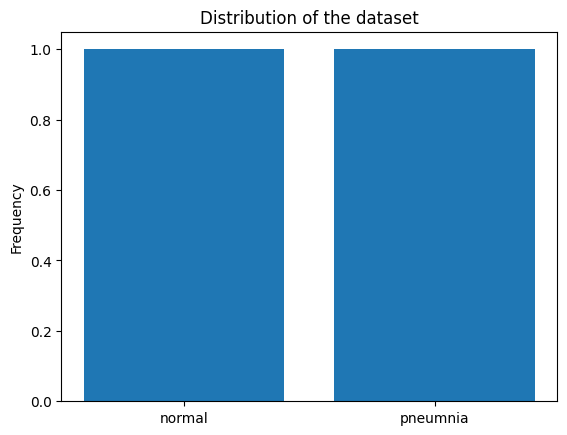

In [ ]:
normal = len(os.listdir('./data/train/NORMAL')) 
pneumonia = len(os.listdir('./data/train/PNEUMONIA'))

plt.bar(['normal', 'pneumnia'], [normal, pneumonia])
plt.ylabel('Frequency')
plt.title('Distribution of the dataset')
plt.show()

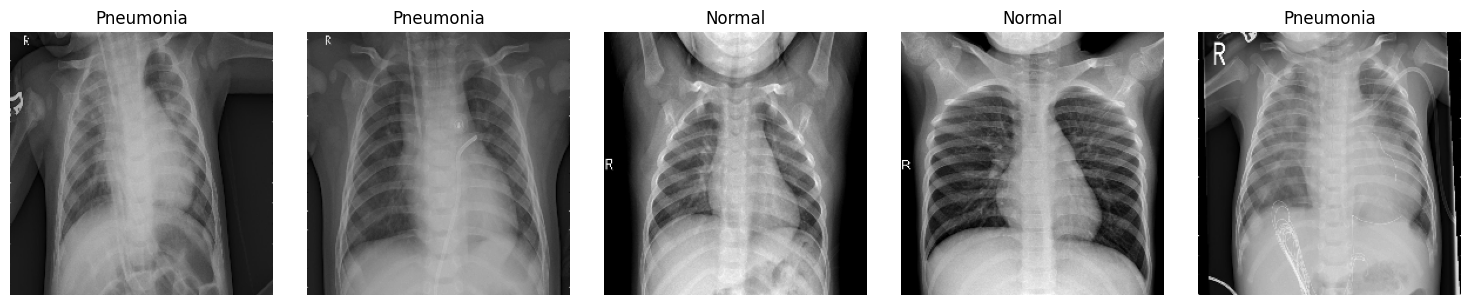

In [6]:
# dispaly 5 random images with their labels
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    random_index = random.randint(0, len(train))# generate a random index
    axs[i].set_title('Normal' if train_labels[random_index] == 0 else 'Pneumonia')
    axs[i].imshow(train[random_index], cmap='gray')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Normalization (divide by 255)
train = train / 255.0 # dividing two integers return an integer in python
val = val / 255.0
test = test / 255.0

### Data Augmentation

In [8]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [9]:
class Data(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.aug_data = []
        self.aug_labels = []

        for img, label in zip(data, labels):
            if label == 1:  # pneumonia
                for _ in range(2):
                    self.aug_data.append(img)
                    self.aug_labels.append(1)
            else:  # normal
                for _ in range(6):
                    self.aug_data.append(img)
                    self.aug_labels.append(0)

    def __len__(self):
        return len(self.aug_data)

    def __getitem__(self, idx):
        image = self.aug_data[idx]
        label = self.aug_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
train_dataset = Data(train, train_labels, train_transform)
val_dataset = Data(val, val_labels, val_test_transform)
test_dataset = Data(test, test_labels, val_test_transform)

In [11]:
# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

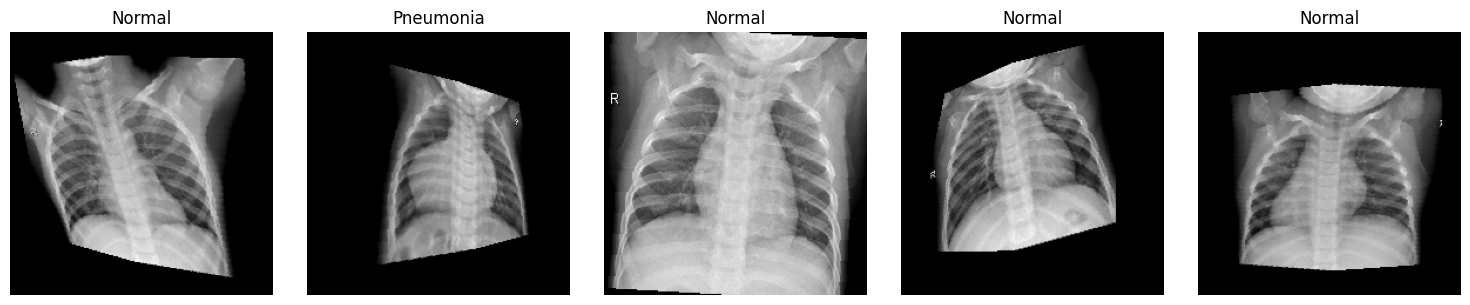

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    random_index = random.randint(0, len(train_dataset) - 1) 
    image, label = train_dataset[random_index]
    image = image.permute(1, 2, 0)  
    axs[i].imshow(image)
    axs[i].set_title('Normal' if label == 0 else 'Pneumonia')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
normal, pneumonia = 0, 0
for images, labels in train_loader:
    normal += (labels == 0).sum().item()
    pneumonia += (labels == 1).sum().item()

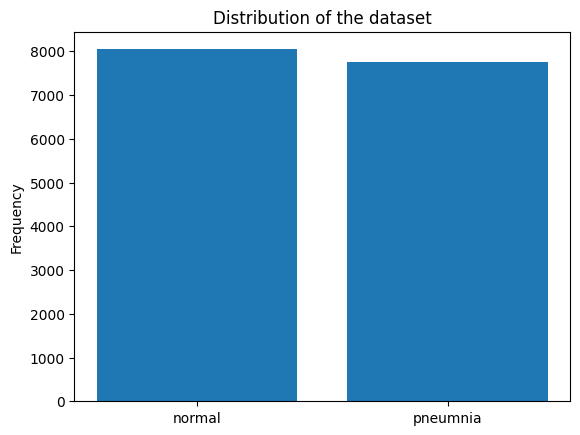

In [17]:
plt.bar(['normal', 'pneumnia'], [normal, pneumonia])
plt.ylabel('Frequency')
plt.title('Distribution of the dataset')
plt.show()

`The dataset is now balanced`

## Modeling

### Resnet50

In [11]:
resnet50 = models.resnet50(pretrained=True)
num_classes = 2
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes) # adapt the last fully connected layer of the resnet50

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


### EfficientNet

In [12]:
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


### VGG16

In [13]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s] 


### MobileNet

In [14]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 141MB/s]


### Kfold Validation

In [15]:
def cross_validate_model(model_class, train_dataset, train_labels, num_classes=2, epochs=5, batch_size=32, lr=1e-4):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    device = ('cuda' if torch.cuda.is_available() else 'cpu')

    mlflow.set_experiment('pneumonia detection')

    with mlflow.start_run():
        folds_train_accuracies = []
        folds_train_losses = []
        folds_val_accuracies = []
        folds_val_losses = []

        mlflow.log_param("model_name", model_class.__name__)

        for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.arange(len(train_labels)), y=train_labels)):
            train_subset = Subset(train_dataset, train_idx)
            val_subset = Subset(train_dataset, val_idx)
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            model = model_class(pretrained=True)

            if hasattr(model, 'fc'):
                num_ftrs = model.fc.in_features
                model.fc = nn.Linear(num_ftrs, num_classes)
            elif hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
                num_ftrs = model.classifier[-1].in_features
                model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
            else:
                raise ValueError("Model architecture not recognized.")

            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            mlflow.log_param('lr', lr)
            mlflow.log_param('optimizer', type(optimizer).__name__)

            train_accuracies, train_losses = [], []
            val_accuracies, val_losses = [], []

            for epoch in range(epochs):
                model.train()
                running_loss, correct, total = 0, 0, 0

                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                train_accuracy = correct / total
                train_loss = running_loss / total
                train_accuracies.append(round(train_accuracy, 4))
                train_losses.append(round(train_loss, 4))
                print(f"Fold {fold}, Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

                model.eval()
                with torch.no_grad():
                    val_correct, val_total, running_val_loss = 0, 0, 0
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        running_val_loss += loss.item() * images.size(0)
                        _, predicted = torch.max(outputs, 1)
                        val_correct += (predicted == labels).sum().item()
                        val_total += labels.size(0)

                    val_accuracy = val_correct / val_total
                    val_loss = running_val_loss / val_total
                    val_accuracies.append(round(val_accuracy, 4))
                    val_losses.append(round(val_loss, 4))
                    print(f"Fold {fold}, Validation Accuracy: {val_accuracy:.4f}")

            mlflow.log_metric('Average epochs train accuracy', round(statistics.mean(train_accuracies), 4))
            mlflow.log_metric('Average epochs train losses', round(statistics.mean(train_losses), 4))
            mlflow.log_metric('Average epochs val accuracies', round(statistics.mean(val_accuracies), 4))
            mlflow.log_metric('Average epochs val losses', round(statistics.mean(val_losses), 4))
            
            folds_train_accuracies.append(statistics.mean(train_accuracies))
            folds_train_losses.append(statistics.mean(train_losses))
            folds_val_accuracies.append(statistics.mean(val_accuracies))
            folds_val_losses.append(statistics.mean(val_losses))

            print(f"Fold {fold} results -> Train Acc: {statistics.mean(train_accuracies):.4f}, Val Acc: {statistics.mean(val_accuracies):.4f}")

        mlflow.log_metric('Average train accuracy folds', round(statistics.mean(folds_train_accuracies), 4))
        mlflow.log_metric('Average val accuracy folds', round(statistics.mean(folds_val_accuracies), 4))
        
        print("==== Cross-validation results ====")
        print(f"Average Train Accuracy: {statistics.mean(folds_train_accuracies):.4f}")
        print(f"Average Val Accuracy:   {statistics.mean(folds_val_accuracies):.4f}")

        mlflow.pytorch.log_model(model, model_class.__name__)
        
    return model

In [16]:
mlflow.set_tracking_uri('./mlrunsss')

In [18]:
resnet_model = cross_validate_model(models.resnet50, train_dataset, train_labels)
vgg_model = cross_validate_model(models.vgg16, train_dataset, train_labels)
efficientnet_model = cross_validate_model(models.efficientnet_b0, train_dataset, train_labels)
mobilenet_model = cross_validate_model(models.mobilenet_v2, train_dataset, train_labels)

2025/08/27 19:59:21 INFO mlflow.tracking.fluent: Experiment with name 'pneumonia detection' does not exist. Creating a new experiment.
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 0, Epoch 1/5, Loss: 0.0295, Accuracy: 0.9897
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 2/5, Loss: 0.0004, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 3/5, Loss: 0.0002, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 4/5, Loss: 0.0001, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 5/5, Loss: 0.0001, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0 results -> Train Acc: 0.9979, Val Acc: 1.0000
Fold 1, Epoch 1/5, Loss: 0.0139, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 2/5, Loss: 0.0002, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 3/5, Loss: 0.0001, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 4/5, Loss: 0.0001, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 5/5, Loss: 0.0000, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1 results -> Train Acc: 1.0000, Val Acc: 1.0000
Fold 2, Epoch 1/5, Loss: 0.0151, A

2025/08/27 20:23:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fold 4, Validation Accuracy: 1.0000
Fold 4 results -> Train Acc: 1.0000, Val Acc: 1.0000
==== Cross-validation results ====
Average Train Accuracy: 0.9990
Average Val Accuracy:   1.0000


2025/08/27 20:23:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 20:23:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 20:23:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-package

Fold 0, Epoch 1/5, Loss: 0.0063, Accuracy: 0.9964
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 2/5, Loss: 0.0000, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 3/5, Loss: 0.0000, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 4/5, Loss: 0.0000, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 5/5, Loss: 0.0000, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0 results -> Train Acc: 0.9993, Val Acc: 1.0000
Fold 1, Epoch 1/5, Loss: 0.0092, Accuracy: 0.9933
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 2/5, Loss: 0.0000, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 3/5, Loss: 0.0000, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 4/5, Loss: 0.0000, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 5/5, Loss: 0.0000, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1 results -> Train Acc: 0.9987, Val Acc: 1.0000
Fold 2, Epoch 1/5, Loss: 0.0046, A

2025/08/27 20:57:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fold 4, Validation Accuracy: 1.0000
Fold 4 results -> Train Acc: 0.9997, Val Acc: 1.0000
==== Cross-validation results ====
Average Train Accuracy: 0.9993
Average Val Accuracy:   1.0000


2025/08/27 20:57:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 20:57:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 20:57:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-package

Fold 0, Epoch 1/5, Loss: 0.0866, Accuracy: 0.9859
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 2/5, Loss: 0.0023, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 3/5, Loss: 0.0011, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 4/5, Loss: 0.0007, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 5/5, Loss: 0.0004, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0 results -> Train Acc: 0.9972, Val Acc: 1.0000
Fold 1, Epoch 1/5, Loss: 0.0997, Accuracy: 0.9734
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 2/5, Loss: 0.0028, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 3/5, Loss: 0.0013, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 4/5, Loss: 0.0008, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 5/5, Loss: 0.0005, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1 results -> Train Acc: 0.9947, Val Acc: 1.0000
Fold 2, Epoch 1/5, Loss: 0.0976, A

2025/08/27 21:10:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/27 21:10:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Fold 4, Validation Accuracy: 1.0000
Fold 4 results -> Train Acc: 0.9966, Val Acc: 1.0000
==== Cross-validation results ====
Average Train Accuracy: 0.9961
Average Val Accuracy:   1.0000


2025/08/27 21:11:08 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 21:11:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in 

Fold 0, Epoch 1/5, Loss: 0.0744, Accuracy: 0.9799
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 2/5, Loss: 0.0032, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 3/5, Loss: 0.0014, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 4/5, Loss: 0.0008, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0, Epoch 5/5, Loss: 0.0005, Accuracy: 1.0000
Fold 0, Validation Accuracy: 1.0000
Fold 0 results -> Train Acc: 0.9960, Val Acc: 1.0000
Fold 1, Epoch 1/5, Loss: 0.0850, Accuracy: 0.9696
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 2/5, Loss: 0.0032, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 3/5, Loss: 0.0012, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 4/5, Loss: 0.0006, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1, Epoch 5/5, Loss: 0.0004, Accuracy: 1.0000
Fold 1, Validation Accuracy: 1.0000
Fold 1 results -> Train Acc: 0.9939, Val Acc: 1.0000
Fold 2, Epoch 1/5, Loss: 0.0815, A

2025/08/27 21:22:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/27 21:22:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Fold 4, Validation Accuracy: 1.0000
Fold 4 results -> Train Acc: 0.9981, Val Acc: 1.0000
==== Cross-validation results ====
Average Train Accuracy: 0.9962
Average Val Accuracy:   1.0000


2025/08/27 21:22:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 21:22:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
def train_model(model_fn, train_dataset, device, epochs=5, lr=1e-4, batch_size=32, num_classes=2):
    model = model_fn(pretrained=True)
    
    if hasattr(model, "classifier"):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, "fc"):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Architecture non supportée")

    with mlflow.start_run(run_name=f"train_{model_fn.__name__}"):
        mlflow.log_param("model", model_fn.__name__)
        mlflow.log_param("lr", lr)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("criterion", "CrossEntropyLoss")

        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_accuracies, train_losses = [], []

        for epoch in range(epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            train_accuracy = correct / total
            train_loss = running_loss / total
            train_accuracies.append(round(train_accuracy, 4))
            train_losses.append(round(train_loss, 4))
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        print(f"{model_fn.__name__} training finished.")
        mlflow.log_metric("Average train accuracy", round(statistics.mean(train_accuracies), 4))
        mlflow.log_metric("Average train loss", round(statistics.mean(train_losses), 4))

        mlflow.pytorch.log_model(model, artifact_path=model_fn.__name__)

    return model, train_losses, train_accuracies


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

vgg16_model, loss_vgg, acc_vgg = train_model(torchvision.models.vgg16, train_dataset, device)
resnet50_model, loss_resnet, acc_resnet = train_model(torchvision.models.resnet50, train_dataset, device)
mobilenet_model, loss_mobilenet, acc_mobilenet = train_model(torchvision.models.mobilenet_v2, train_dataset, device)
efficientnet_model, loss_efficientnet, acc_efficientnet = train_model(torchvision.models.efficientnet_b0, train_dataset, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.1661, Accuracy: 0.9369
Epoch 2/5, Loss: 0.0866, Accuracy: 0.9681
Epoch 3/5, Loss: 0.0722, Accuracy: 0.9750
Epoch 4/5, Loss: 0.0634, Accuracy: 0.9780


2025/08/27 21:53:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 5/5, Loss: 0.0541, Accuracy: 0.9804
vgg16 training finished.


2025/08/27 21:53:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 21:53:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 21:53:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-package

Epoch 1/5, Loss: 0.1060, Accuracy: 0.9576
Epoch 2/5, Loss: 0.0590, Accuracy: 0.9784
Epoch 3/5, Loss: 0.0472, Accuracy: 0.9824
Epoch 4/5, Loss: 0.0436, Accuracy: 0.9846


2025/08/27 22:10:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/27 22:10:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 5/5, Loss: 0.0302, Accuracy: 0.9894
resnet50 training finished.


2025/08/27 22:10:34 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 22:10:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/5, Loss: 0.1133, Accuracy: 0.9576
Epoch 2/5, Loss: 0.0672, Accuracy: 0.9746
Epoch 3/5, Loss: 0.0517, Accuracy: 0.9820
Epoch 4/5, Loss: 0.0446, Accuracy: 0.9852


2025/08/27 22:18:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/27 22:18:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 5/5, Loss: 0.0420, Accuracy: 0.9847
mobilenet_v2 training finished.


2025/08/27 22:18:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 22:18:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(ms

Epoch 1/5, Loss: 0.1297, Accuracy: 0.9564
Epoch 2/5, Loss: 0.0611, Accuracy: 0.9790
Epoch 3/5, Loss: 0.0440, Accuracy: 0.9846
Epoch 4/5, Loss: 0.0341, Accuracy: 0.9877


2025/08/27 22:27:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/27 22:27:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 5/5, Loss: 0.0291, Accuracy: 0.9911
efficientnet_b0 training finished.


2025/08/27 22:27:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/27 22:27:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Evaluation

In [28]:
def evaluate_model(model, test_loader=test_loader):
    true_labels = []
    predictions = []
    probs = []
    model_name = model.__class__.__name__

    with mlflow.start_run(run_name=f"Evaluate {model_name}"):
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        # Metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, zero_division=0)
        recall = recall_score(true_labels, predictions, zero_division=0)
        f1 = f1_score(true_labels, predictions, zero_division=0)

        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('f1', f1)

        print(f'{model_name} accuracy: {round(accuracy, 2)}')
        print(f'{model_name} precision: {round(precision, 2)}')
        print(f'{model_name} recall: {round(recall, 2)}')
        print(f'{model_name} f1-score: {round(f1, 2)}')

        # Classification report
        print(f'-------------\n{model_name} classification report -------------------')
        print(classification_report(true_labels, predictions, zero_division=0))

        # Confusion matrix with seaborn
        print(f'-------------\n{model_name} confusion matrix -------------------')
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
        plt.title(f"{model_name} - Confusion Matrix")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.show()

        # ROC curve
        print(f'-------------\n{model_name} ROC Curve -------------------')
        fpr, tpr, thresholds = roc_curve(true_labels, probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("roc_curve.png")
        mlflow.log_artifact("roc_curve.png")
        plt.show()


VGG accuracy: 0.55
VGG precision: 0.45
VGG recall: 1.0
VGG f1-score: 0.62
-------------
VGG classification report -------------------
              precision    recall  f1-score   support

           0       1.00      0.31      0.47      1404
           1       0.45      1.00      0.62       780

    accuracy                           0.55      2184
   macro avg       0.72      0.65      0.54      2184
weighted avg       0.80      0.55      0.52      2184

-------------
VGG confusion matrix -------------------


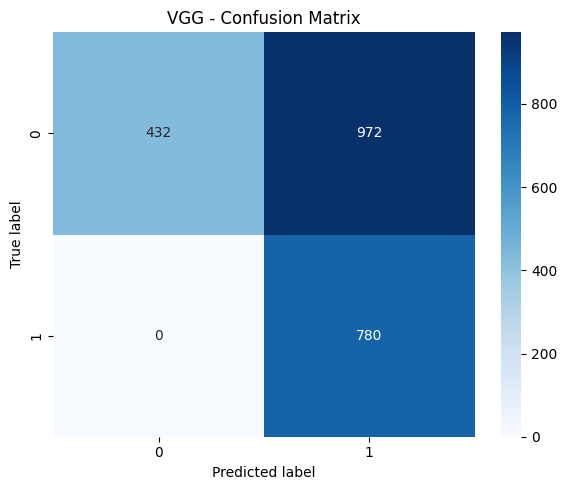

-------------
VGG ROC Curve -------------------


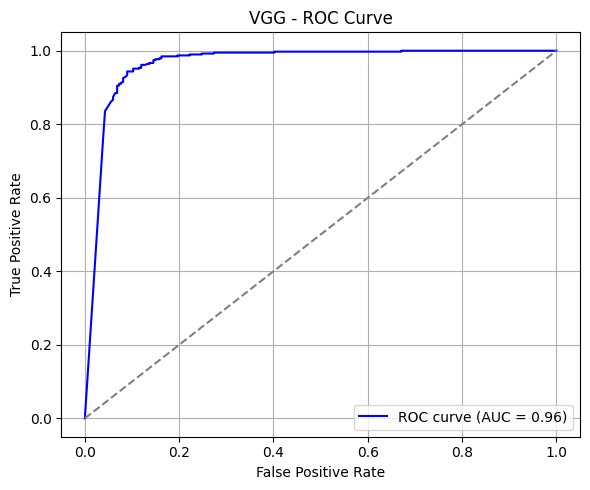

ResNet accuracy: 0.86
ResNet precision: 0.72
ResNet recall: 0.99
ResNet f1-score: 0.83
-------------
ResNet classification report -------------------
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1404
           1       0.72      0.99      0.83       780

    accuracy                           0.86      2184
   macro avg       0.86      0.89      0.85      2184
weighted avg       0.89      0.86      0.86      2184

-------------
ResNet confusion matrix -------------------


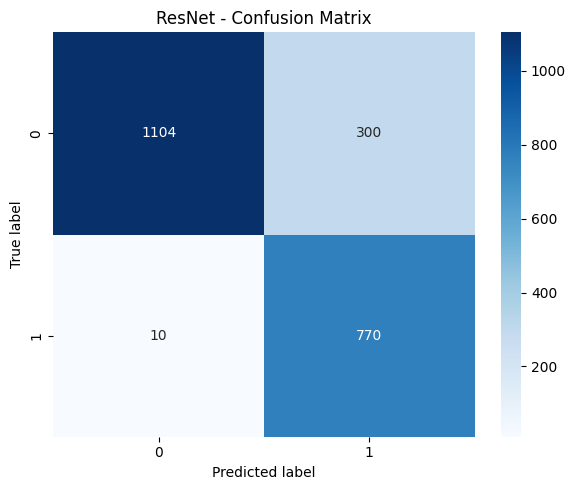

-------------
ResNet ROC Curve -------------------


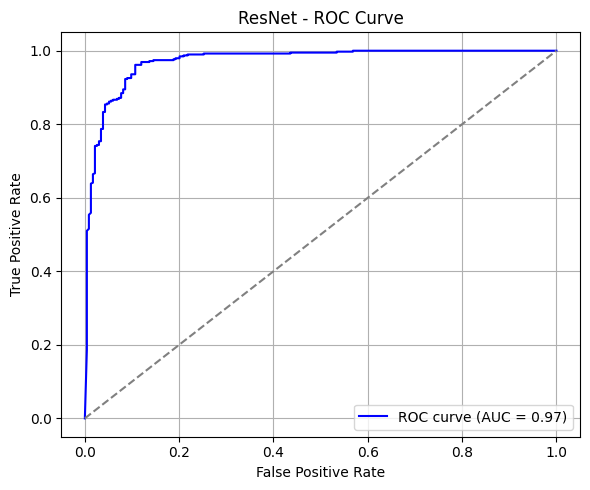

EfficientNet accuracy: 0.77
EfficientNet precision: 0.61
EfficientNet recall: 0.99
EfficientNet f1-score: 0.76
-------------
EfficientNet classification report -------------------
              precision    recall  f1-score   support

           0       0.99      0.65      0.79      1404
           1       0.61      0.99      0.76       780

    accuracy                           0.77      2184
   macro avg       0.80      0.82      0.77      2184
weighted avg       0.86      0.77      0.78      2184

-------------
EfficientNet confusion matrix -------------------


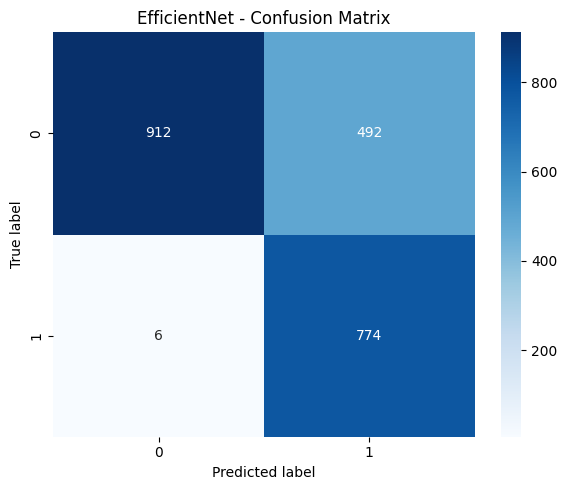

-------------
EfficientNet ROC Curve -------------------


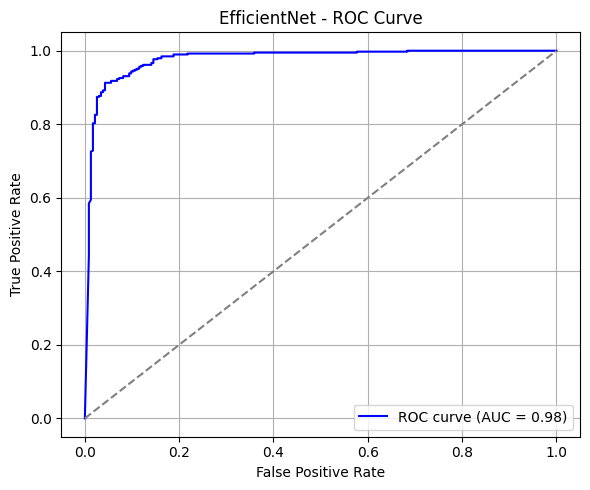

MobileNetV2 accuracy: 0.9
MobileNetV2 precision: 0.78
MobileNetV2 recall: 0.98
MobileNetV2 f1-score: 0.87
-------------
MobileNetV2 classification report -------------------
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1404
           1       0.78      0.98      0.87       780

    accuracy                           0.90      2184
   macro avg       0.89      0.92      0.89      2184
weighted avg       0.92      0.90      0.90      2184

-------------
MobileNetV2 confusion matrix -------------------


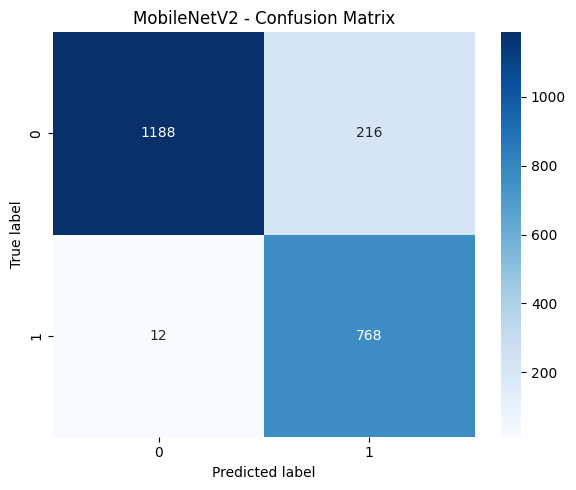

-------------
MobileNetV2 ROC Curve -------------------


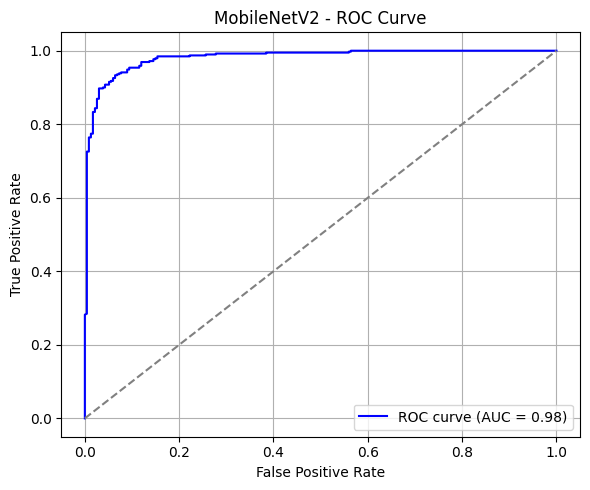

In [30]:
evaluate_model(vgg16_model)
evaluate_model(resnet50_model)
evaluate_model(efficientnet_model)
evaluate_model(mobilenet_model)

## Visualize Predicitons

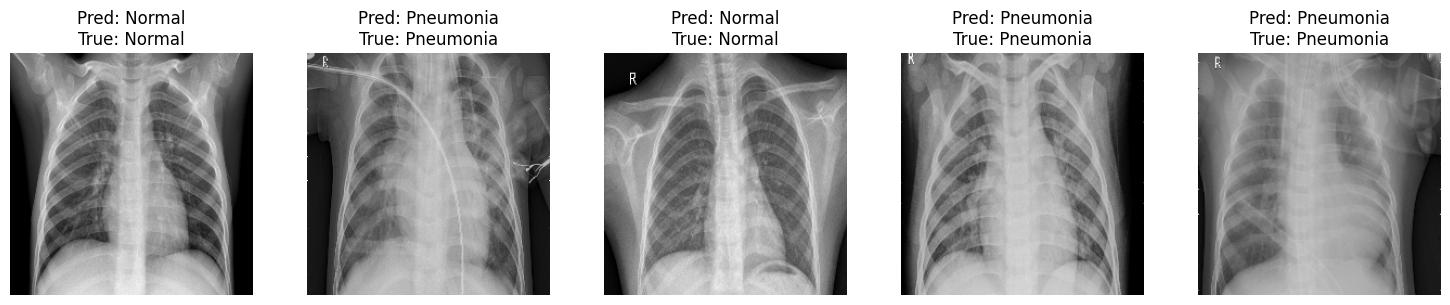

In [36]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
resnet50_model.eval()

with torch.no_grad():
    for i in range(5):
        random_index = random.randint(0, len(test_dataset)-1)
        image, true_class = test_dataset[random_index]
        input_tensor = image.unsqueeze(0).to(device)
        outputs = resnet50_model(input_tensor)
        _, predicted_class = torch.max(outputs, 1)
        pred_class = "Normal" if predicted_class.item() == 0 else "Pneumonia"
        true_class_label = "Normal" if true_class == 0 else "Pneumonia"
        
        # Handle RGB or grayscale for plotting
        img_disp = image.cpu().numpy()
        if img_disp.shape[0] == 3:  # RGB
            img_disp = img_disp.transpose(1, 2, 0)
        else:  # Grayscale
            img_disp = img_disp.squeeze()
        
        axs[i].imshow(img_disp, cmap='gray' if img_disp.ndim == 2 else None)
        axs[i].set_title(f"Pred: {pred_class}\nTrue: {true_class_label}")
        axs[i].axis('off')

plt.tight_layout()
plt.show()


In [37]:
# Save the model
torch.save(resnet50_model.state_dict(), "resnet50_model.pth")

In [39]:
shutil.make_archive("mlruns", 'zip', "/kaggle/working/mlrunsss")

'/kaggle/working/mlruns.zip'